سهام سفارس

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib as ta

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras import layers
from keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from keras import optimizers
from datetime import datetime, timedelta
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")


In [ ]:
def csv_to_dataset(input_step,out_step,test_per):

    data = pd.read_csv('data4H.csv')
    data.columns = ['Date','Open', 'High', 'Low', 'Close', 'Tick Volume', 'Vol']

    data['Date'] = pd.to_datetime(data['Date'])
    data['Date'] = pd.to_datetime(data.Date)
    
    data.set_index('Date', inplace=True)
    
    start_date = '2019-1-1'
    end_date = '2021-9-1'
    data = data.loc[start_date:end_date].copy()
    
    data = compute_technical_indicators(data.copy())

    data = data.drop(['Open', 'High', 'Low', 'Tick Volume', 'Vol'], axis=1)
    data = data[150:].copy()

    train_data = data[:-1*int(data.shape[0]*test_per)].copy()
 
    data_normaliser = preprocessing.MinMaxScaler()

    train_data_normalised = pd.DataFrame(data_normaliser.fit_transform(train_data),columns=train_data.columns, index=train_data.index)
    data_normalised = pd.DataFrame(data_normaliser.fit_transform(data),columns=data.columns, index=data.index)

    splited_train_data_normalised = split_input_data(train_data_normalised.to_numpy().copy(),input_step,out_step)

    train_next_days_close_normalised = split_output_data(np.expand_dims(train_data_normalised['Close'].to_numpy().copy(),-1),input_step,out_step)

    test_next_days_close= data['Close'].to_numpy().copy()
      
    train_next_days_close = split_output_data(np.expand_dims(train_data['Close'].to_numpy().copy(),-1),input_step,out_step)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(train_next_days_close)

    return splited_train_data_normalised, data_normalised, train_next_days_close_normalised, train_next_days_close,test_next_days_close, y_normaliser


def calc_ema(window_size,d,smoothing=2):
    ema = []
    for i in range(window_size-1):
      ema.append(0)
    ema.append(sum(d[:window_size]) / window_size)
    for price in d[window_size:]:
        ema.append((price * (smoothing / (1 + window_size))) + ema[-1] * (1 - (smoothing / (1 + window_size))))

    return ema


def split_input_data(df,in_step,out_step):

    splited_df = np.array([df[i  : i + in_step].copy() for i in range(len(df) - in_step - out_step+1)])
    return splited_df

def split_output_data(df,in_step,out_step):

    splited_df = np.array([df[i  : i + out_step].copy() for i in range(in_step,len(df) - out_step +1 )])
    return np.squeeze(splited_df)

def compute_technical_indicators(df):
    df['EMA10'] = ta.EMA(df['Close'], timeperiod=10)
    df['EMA20'] = ta.EMA(df['Close'], timeperiod=10)
    df['EMA30'] = ta.EMA(df['Close'], timeperiod=30)
    df['EMA40'] = ta.EMA(df['Close'], timeperiod=40)
    df['EMA50'] = ta.EMA(df['Close'], timeperiod=50)
    df['EMA100'] = ta.EMA(df['Close'], timeperiod=100)

    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)

    macd, macdsignal, macdhist = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACDsignal'] = macdsignal
    df=df.fillna(0).copy()

    return df


In [ ]:
input_steps = 80
output_steps = 10
test_percent = 0.1
x_train, whole_data, y_train, y_train_unscaled,y_test, y_normaliser = csv_to_dataset(input_steps,output_steps,test_percent)


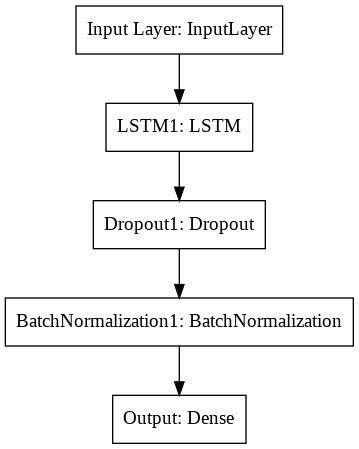

In [ ]:
#model
model = Sequential()

input_layer = Input(x_train[0].shape,name='Input Layer')

x = LSTM(50, return_sequences=False,name= 'LSTM1')(input_layer)
x = Dropout(0.5, name= 'Dropout1')(x)
x = BatchNormalization(name='BatchNormalization1')(x)
output = Dense(output_steps,activation='linear', name='Output')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='mse',metrics = ['accuracy'])

from keras import utils
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=False)


In [ ]:
res = model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split = 0.1)

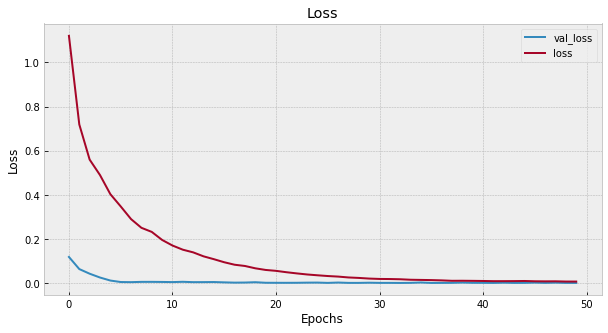

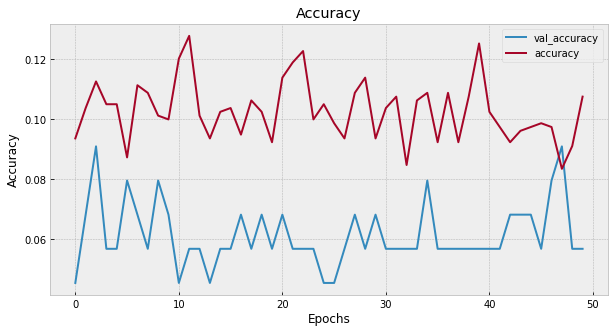

In [ ]:
history = res.history
plt.figure(figsize=(10,5))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
    
plt.figure(figsize=(10,5))
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
predictions = []
for i in range(0,len(whole_data)-output_steps-input_steps+1,output_steps):
        # Creating rolling intervals to predict off of
        x = whole_data[i:i+input_steps].to_numpy()
        # Predicting using rolling intervals
        yhat = model.predict(np.expand_dims(x,0))
        # Transforming values back to their normal prices
        yhat = y_normaliser.inverse_transform(yhat)[0]
        predictions.append(yhat)

predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1])



mapr = [np.abs(y_test[input_steps]-predictions[0])/y_test[input_steps]]

mse = [np.square((y_test[input_steps]-predictions[0])/y_test[input_steps])]

for i in range(len(predictions)-int(len(predictions)*test_percent),len(predictions)):
  mapr.append(np.abs(y_test[input_steps+i]-predictions[i])/y_test[input_steps+i])
  mse.append(np.square((y_test[input_steps+i]-predictions[i])/y_test[input_steps+i]))

mapr = np.mean(np.array(mapr))*100
print("MAPR: ",mapr)
mse = np.sqrt(np.mean(np.array(mse)))*100
print("MSE: ",mse)

import matplotlib.pyplot as plt
plt.gcf().set_size_inches(15, 7, forward=True)

real = plt.plot(y_test[-1*int(len(y_test)*test_percent):], label='real')
pred = plt.plot(predictions[-1*int(len(y_test)*test_percent):], label='predicted')

plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend(['Real', 'Predicted'])
plt.savefig('testRes.png')
plt.show()